In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def com_distance_to_pmf(file, bins):
    ''' Load COM distance as a function of MC steps and calculate potential of mean forece (PMF) '''
    p, r = np.histogram(np.loadtxt(file), bins=bins)
    r = r[1:] / 2 + r[0:-1] / 2
    dr = r[1] - r[0]
    r_max = r[-1]
    gofr = p / p.sum() * r_max / dr # g(r)
    pmf = -np.log(gofr)             # w(r)/kT
    print(f"r_min = {r[0]}, r_max = {r_max} Å, dr = {dr} Å")
    return r, pmf

r_min = 38.06762962962963, r_max = 105.77237037037037 Å, dr = 0.5052592592592546 Å


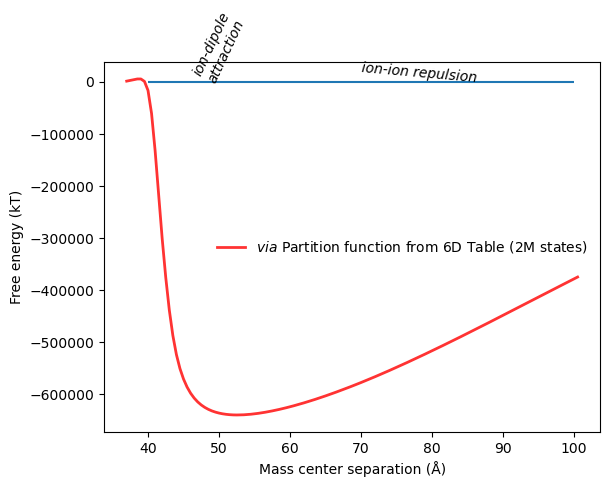

In [13]:
r, pmf = com_distance_to_pmf("com_distance.dat.gz", bins=135)
#plt.hlines(0, xmin=r[0], xmax=r[-1], color='k', alpha=0.5, ls='--', lw=2)
#plt.plot(r, pmf - 0.65, 'bo', lw=3, label="Metropolis-Hastings Monte-Carlo (2M trial moves)", alpha=0.7, ms=4)

r, pmf = np.loadtxt("virialize-pmf.dat", usecols=[0,1], unpack=True)
plt.plot(r, np.cumsum(-np.expm1(-pmf) * r * r), label="$via$ Partition function from 6D Table (2M states)", lw=2, alpha=0.8, color='red')

plt.ylabel("Free energy (kT)")
plt.xlabel("Mass center separation (Å)")
plt.legend(loc=0, frameon=False)
#plt.xlim(37, 100)
#plt.ylim(-4.2, 4)
plt.text(70, 1.1, "ion-ion repulsion", rotation=-5, fontstyle='italic')
plt.hlines(xmin=40, xmax=100, y=0)
plt.text(46, -3, "ion-dipole\nattraction", rotation=65, fontstyle='italic')
plt.savefig("twobody.png", bbox_inches="tight", dpi=300)